# Importar Bibliotecas Necessárias

In [70]:
# Importar as bibliotecas

# -*- coding: utf-8 -*-

# Machine Learning
import pandas as pd
import tensorflow as tf
from scipy.fft import fft
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Flatten
from sklearn.model_selection import train_test_split


# Bibliotecas do Sistema
import os
import random
import serial
import argparse
import serial.tools.list_ports
from datetime import datetime

# Bibliotecas matemáticas
import numpy as np
from math import sqrt
from numpy.random import seed
import matplotlib.pyplot as plt

# https://www.linkedin.com/pulse/lendo-arquivos-csv-com-pandas-rog%C3%A9rio-guimar%C3%A3es-de-campos-j%C3%BAnior/
# https://stackabuse.com/python-list-files-in-a-directory/

# Transformar os Dados

In [2]:
# Transforma de str para float

def str2float(Part):
    for i in range(0, len(Part)):
        Part[i] = Part[i].split(';')
        for j in range(0, len(Part[i])):
            Part[i][j] = (float(Part[i][j].replace(',', '.'))-1.8)

    return Part

# Carregar o Dataset

In [98]:
# Carregar dados MPL para modelo RNN

# Definição do paciente e os diretórios
nome = "Anderson_CH2_MSE"

# Caminho dos dados
filename = f"Dataset\\{nome}\\dados_classificacao.csv"
filename_limiar = f"Dataset\\{nome}\\limiar.txt"
filename_movimentos = f"Dataset\\{nome}\\movimentos_classificacao.csv"


In [99]:
lines = []
y = []
qty_lines = 40

with open(filename, 'r') as f:
    for i in range(0, qty_lines):
        lines.append(f.readline())
        lines.append

with open(filename_movimentos, 'r') as f:
    for i in range(0, qty_lines):
        read_data = f.readline()
        read_data = list(read_data.split(';'))
        for j in range(0, len(read_data)):
            read_data[j] = int(read_data[j])
        y.append(read_data)

#display(lines[0])
lines = str2float(lines)



# Declaração das Funções para Extração dos Dados

In [100]:
# Root Mean Square (RMS) 

def f_rms(dado, segments):
    Vrms = []
    
    segment = int(len(dado)/segments)
    aux = 0
    aux_2 = segment
    
    for s in range(0, segments): 
        soma = 0
        aux_2 = segment * (s+1)
        for sample in range(aux, aux_2):
            soma = soma + (dado[sample] ** 2) 

        Vrms.append(sqrt(soma/segment))
        aux = aux_2 - 1

    return Vrms

In [101]:
# Comprimento do traço do sinal (WL)

def waveform_length(dado, segments):
    # segment[sample] = Xk
    # segment[sample-1] = Xk-1
    
    l0_list = []
    
    segment = int(len(dado)/segments)
    aux = 0
    aux_2 = segment
    
    for s in range(0, segments):
        l0 = 0
        aux_2 = segment * (s+1)
        for sample in range(aux, aux_2):
            l0 = l0 + abs(dado[sample] - dado[sample-1])
        
        l0_list.append(l0)
        aux = aux_2
        
    # print (f"l0: {l0_list}")
    return l0_list

In [102]:
# Média do Valor Absoluta (MAV)

# Recebe uma amostra com 400 pontos e faz a media absoluta baseada na quantidade de segmentos
def mean_absolute_value(dado, segments):
    MAV = []
    
    segment = int(len(dado)/segments)
    aux = 0
    aux_2 = segment
    
    
    for s in range(0, segments): 
        soma = 0
        aux_2 = segment * (s+1)
        for sample in range(aux, aux_2):
                soma = soma + abs(float(dado[sample]))
    
        MAV.append(soma/segment)
        aux = aux_2 - 1
        
    # print (f"MAV: {MAV}")
    return MAV

In [103]:
# Zero Crossing (ZC)

def zero_crossing(dado, segments): 
    ZC = []

    segment = int(len(dado)/segments)
    aux = 0
    aux_2 = segment
    
    # X0 = Xk
    # X1 = Xk+1
    
    for s in range(0, segments): 
        count = 0
        aux_2 = segment * (s+1)
        for sample in range(aux, aux_2-1):
            X0 = dado[sample]
            X1 = dado[sample + 1]
            # abs(Xk - Xk-1) >= 10mV
            # limiar (threshhold) = 10mV. Noise INA332 = 7uVp-p. Para ter contagem de ZC falsos
            if (((X0 > 0 and X1 < 0) or (X0 < 0 and X1 > 0)) and (abs(X0 - X1) >= 0.01)):
                count += 1
                # print (f"Diferença para ZC: {abs(X0 - X1)}")
        
        ZC.append(count)
        aux = aux_2 - 1
    
    # print (f"ZC: {ZC}")    
    return ZC
    
    

In [104]:
# A mudança de sinais (SSC)

def slope_sign_changes(dado, segments):
    SSC = []
    
    # X0 = Xk-1
    # X1 = Xk
    # X2 = Xk+1
    
    segment = int(len(dado)/segments)
    aux = 1
    aux_2 = segment
    
    for s in range(0, segments): 
        count = 0
        aux_2 = segment * (s+1)
        for sample in range(aux, aux_2 - 1):
            X0 = dado[sample - 1]
            X1 = dado[sample]
            X2 = dado[sample + 1]
            if (((X1 > X0  and X1 > X2) or (X1 < X0 and X1 < X2)) and ((abs(X1 - X2) >= 0.01) or (abs(X1 - X0) >= 0.01))):
                count += 1
                
        SSC.append(count)
        aux = aux_2 - 1
    
    # print (f"SSC: {SSC}")
    return SSC

In [105]:
# Ângulo de inclinação da média do valor absoluto (MAVSL)

def mean_absolute_value_slope(dado, segments):
    # MAV = Xi
    # MAV1 = Xi+1
    
    MAVSLP = []
    MAV = mean_absolute_value(dado, segments)
    
    MAVSLP.append(0.0)
    for s in range(0, (segments-1)):
        MAVSLP.append(abs(MAV[s+1] - MAV[s])) 
    
    
    
    # print (f"MAVSLP{MAVSLP}")        
    return MAVSLP

In [106]:
def FFT(data_part, N):
    # Numero de pontos
    #N = 400 # 200ms
    # Espaçamento da amostra
    T = 1.0 / 1000.0

    # FFT
    yf = fft(data_part)
    #print(f"FFT: {yf}")
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    
    plt.rcParams["figure.figsize"] = (15,5)
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]), color='blue')
    plt.axis([0, 500, 0, 0.025])
    plt.title("FFT - Flexão - Músculo: Flexor superficial dos dedos")

    plt.grid(True)
    plt.xlabel("Frequência (Hz)")
    plt.ylabel("Amplitude (V)")
    plt.show()

# Extração dos Pontos Referentes a Contração

In [107]:
# Detecta o impulso baseado no ruído em repouso do músculo
def delta_dirac(data_full, filename_limiar, N, janela):
    # Valor obtido empiricamente utilizando o repouso
    with open(filename_limiar, 'r') as l:
        limiar = l.read()
    
    limiar = float(limiar) - 1.8
    segments = 1
    
    # Compara se algum dos valores é maior que o limiar, caso sim efetua o RMS
    # dos próximos 40 pontos (baseado em Rodrigo Ortolan)
    # Se o RMS desses 40 pontos for maior que o limiar considera este o inicio da contração 
    # E retorna 400 pontos referentes aos 200ms do começo do sinal
    for row in range(0, len(data_full)):
        if data_full[row] > limiar:
            rms = f_rms(data_full[row:(row + janela)], segments)
            if (rms[0]) > limiar:
                #print (row)
                data_part = data_full[row:(row + N)]
                
                return data_part

In [108]:
# Definição de parâmetros para obtenção dos 200ms
N = 400
janela = 10

Part = []
i = 0

for line in lines:
    #print (i)
    det = delta_dirac(line, filename_limiar, N, janela) 
    if (det != None):
        Part.append(det)
    else:
        y[i] = -1
    i += 1
    
while (-1 in y):
    y.remove(-1)

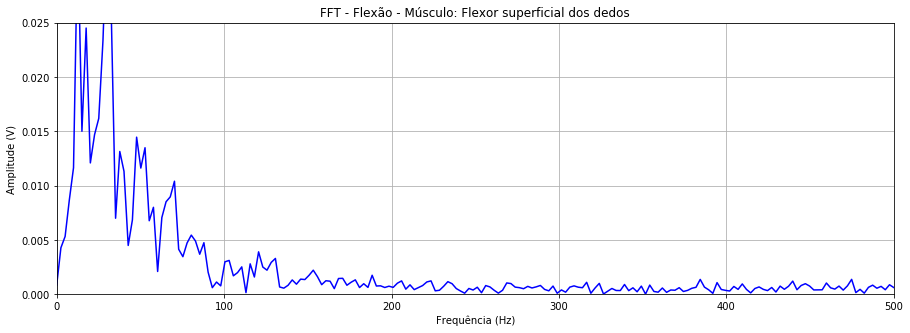

In [109]:
# GERAR FFT PARA MONOGRAFIA
FFT(Part[1], N)


# Normalização dos Dados

In [110]:
# Normalizar os dados entre -1 a 1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
Part_normalize = scaler.fit_transform(Part)

display(Part_normalize)

array([[-1.00000000e+00, -3.33333333e-01, -2.00000000e-01, ...,
        -1.25000000e-01, -1.57894737e-01,  1.11111111e-01],
       [-1.00000000e+00,  3.55271368e-15,  2.44249065e-15, ...,
         6.25000000e-01,  8.94736842e-01,  8.51851852e-01],
       [-1.00000000e+00, -6.66666667e-01, -4.00000000e-01, ...,
         5.00000000e-01,  3.68421053e-01,  2.59259259e-01],
       ...,
       [-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, ...,
         2.50000000e-01,  4.73684211e-01,  4.07407407e-01],
       [ 3.33333333e-01,  3.33333333e-01,  4.00000000e-01, ...,
         1.55431223e-15,  5.26315789e-02,  2.59259259e-01],
       [-1.00000000e+00,  3.55271368e-15,  2.44249065e-15, ...,
         6.25000000e-01,  5.78947368e-01,  4.81481481e-01]])

# Estabelecendo Padrão dos Dados

In [103]:
X_df = pd.DataFrame(data=Part_normalize)
y_df = pd.DataFrame(data=y)

display(X_df.shape)
display(y_df.shape)

(40, 400)

(40, 1)

In [104]:
# Verificar a média dos 400 pontos
media_linha_flexor = np.mean(X_df[0:19], axis = 0)
media_linha_flexor2 = np.mean(X_df[40:59], axis = 0)
media_linha_extensao = np.mean(X_df[20:39], axis = 0)
media_linha_extensao2 = np.mean(X_df[60:79], axis = 0)

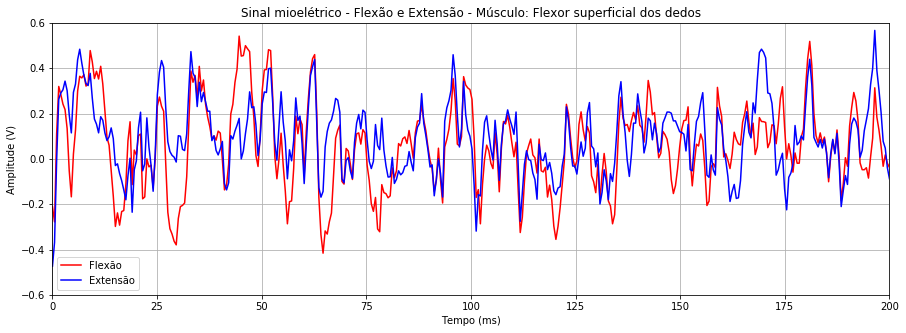

In [105]:
# Padrão da flexão com dois músculos
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0,200,num=400)

plt.rcParams["figure.figsize"] = (15,5)
plt.plot( x, media_linha_flexor, color='red', label='Flexão') # linha pontilha orange
plt.plot( x, media_linha_extensao, color='blue', label='Extensão')

plt.axis([0, 200, -0.6, 0.6])
plt.title("Sinal mioelétrico - Flexão e Extensão - Músculo: Flexor superficial dos dedos")

plt.grid(True)
plt.xlabel("Tempo (ms)")
plt.ylabel("Amplitude (V)")
plt.legend(loc='best')
plt.show()

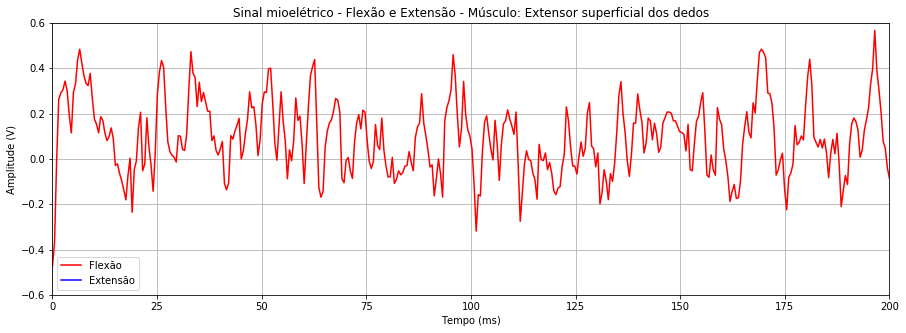

In [107]:
# Padrão da extensão com dois músculos
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0,200,num=400)

plt.rcParams["figure.figsize"] = (15,5)
plt.plot( x, media_linha_flexor2, color='red', label='Flexão') # linha pontilha orange
plt.plot( x, media_linha_extensao2, color='blue', label='Extensão')

plt.axis([0, 200, -0.6, 0.6])
plt.title("Sinal mioelétrico - Flexão e Extensão - Músculo: Extensor superficial dos dedos")

plt.grid(True)
plt.xlabel("Tempo (ms)")
plt.ylabel("Amplitude (V)")
plt.legend(loc='best')
plt.show()

# TESTE COM 400 PONTOS NA LSTM

In [11]:
X_df = np.array(Part_normalize)
y_df = np.array(y)

X_df = np.reshape(X_df, (80,400,1))

display(X_df.shape)
display(y_df.shape)

(80, 400, 1)

(80, 1)

# Tratamento dos Dados

In [111]:
# Extração de informações dos Dados 

# Caso use somente um segmento tem que excluir o parâmetro de MAVSL

segments = 5

X = np.ones((len(Part_normalize), segments, 6))

# Extrair características
for idx,p in enumerate(Part_normalize):
    X[idx,:,0] = mean_absolute_value(p, segments)
    X[idx,:,1] = waveform_length(p, segments)
    X[idx,:,2] = f_rms(p, segments)
    X[idx,:,3] = mean_absolute_value_slope(p, segments)
    X[idx,:,4] = zero_crossing(p, segments)
    X[idx,:,5] = slope_sign_changes(p, segments)

# Reshape deve ser: (quantidade de amostras, 3)
y = np.array(y)

display(X[0,:,:])
display(X[0,:,0])
display(X.shape)

array([[2.61400816e-01, 1.30841372e+01, 3.50222250e-01, 0.00000000e+00,
        1.70000000e+01, 2.90000000e+01],
       [6.01304091e-01, 1.08920433e+01, 6.81790660e-01, 3.39903275e-01,
        7.00000000e+00, 1.90000000e+01],
       [2.74810484e-01, 9.27914394e+00, 3.16339740e-01, 3.26493607e-01,
        9.00000000e+00, 3.20000000e+01],
       [3.66917907e-01, 1.00834074e+01, 4.53661719e-01, 9.21074233e-02,
        7.00000000e+00, 3.40000000e+01],
       [3.79774713e-01, 1.15270488e+01, 4.46627939e-01, 1.28568060e-02,
        7.00000000e+00, 3.80000000e+01]])

array([0.26140082, 0.60130409, 0.27481048, 0.36691791, 0.37977471])

(40, 5, 6)

# Separação de Treino e Teste

In [112]:
# Treino para LSTM e MLP com Features
seed(2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

display(X_train.shape)
display(y_train.shape)
display(X_test.shape)
display(y_test.shape)

(32, 5, 6)

(32, 1)

(8, 5, 6)

(8, 1)

In [72]:
# Treino para MLP com 400 pontos
seed(2)

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, stratify = y)

display(X_train.shape)
display(y_train.shape)
display(X_test.shape)
display(y_test.shape)

NameError: name 'X_df' is not defined

# Gráficos

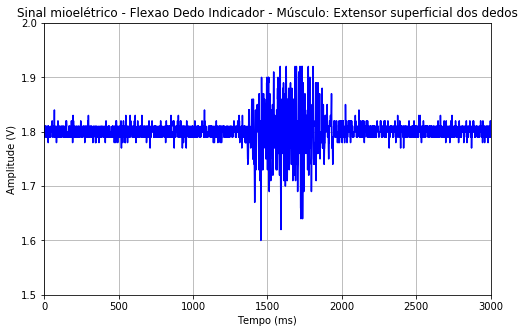

In [32]:
# Amostra inteira flexão CH1: 6000 pontos = 3 segundos
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0,3000,num=6000)

plt.rcParams["figure.figsize"] = (8,5)
plt.plot( x, lines[15], color='blue') # linha pontilha orange

plt.axis([0, 3000, 1.5, 2])
plt.title("Sinal mioelétrico - Flexao Dedo Indicador - Músculo: Extensor superficial dos dedos")

plt.grid(True)
plt.xlabel("Tempo (ms)")
plt.ylabel("Amplitude (V)")
plt.show()

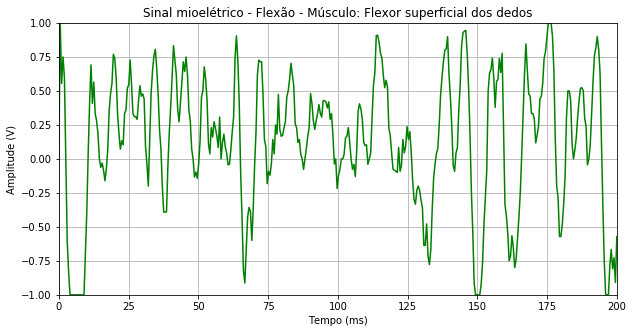

In [87]:
# Amostra parcial flexão CH1: 400 pontos = 200 millisegundos
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0,200,num=400)

plt.rcParams["figure.figsize"] = (10,5)
plt.plot( x, Part_normalize[10], color='green') # linha pontilha orange

plt.axis([0, 200, -1, 1])
plt.title("Sinal mioelétrico - Flexão - Músculo: Flexor superficial dos dedos")

plt.grid(True)
plt.xlabel("Tempo (ms)")
plt.ylabel("Amplitude (V)")
plt.show()

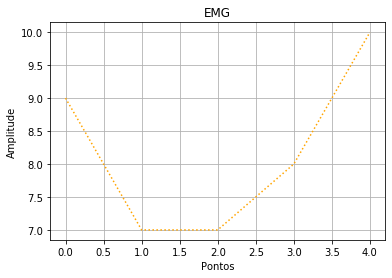

In [19]:
# Extração de características: 400 pontos = 200 millisegundos
import numpy as np
import matplotlib.pyplot as plt

x = np.array(range(len(X[0,:,0])))

plt.plot( x, X[1,:,4], 'k:', color='orange') # linha pontilha orange

#plt.axis([0, 4, 0, 1])
plt.title("EMG")

plt.grid(True)
plt.xlabel("Pontos")
plt.ylabel("Amplitude")
plt.show()

# Aplicação da Rede MLP

In [122]:
# Construção da Rede MLP

model = Sequential()
model.add(Input(shape=(5,6,)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 30)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 31        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


# Aplicação da Rede LSTM

In [175]:
# Construção da Rede LSTM

model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 64)                18176     
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 65        
Total params: 18,241
Trainable params: 18,241
Non-trainable params: 0
_________________________________________________________________


# Aplicação da Rede GRU

In [187]:
# Construção da Rede GRU

model = Sequential()
model.add(GRU(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_7 (GRU)                  (None, 64)                13632     
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 65        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________


# Métricas

In [123]:
# Definição da Loss Function (Loss) e Accuracy (Acc)

opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Fit Model

In [124]:
# fit network
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test), shuffle=True)

Train on 32 samples, validate on 8 samples
Epoch 1/50
32/32 [==============================] - 1s 26ms/sample - loss: 11.5419 - acc: 0.5000 - val_loss: 10.2274 - val_acc: 0.5000
Epoch 2/50
32/32 [==============================] - 0s 665us/sample - loss: 10.9405 - acc: 0.5000 - val_loss: 9.6782 - val_acc: 0.5000
Epoch 3/50
32/32 [==============================] - 0s 766us/sample - loss: 10.3994 - acc: 0.5000 - val_loss: 9.1204 - val_acc: 0.5000
Epoch 4/50
32/32 [==============================] - 0s 485us/sample - loss: 9.8449 - acc: 0.5000 - val_loss: 8.5692 - val_acc: 0.5000
Epoch 5/50
32/32 [==============================] - 0s 495us/sample - loss: 9.2984 - acc: 0.5000 - val_loss: 8.0232 - val_acc: 0.5000
Epoch 6/50
32/32 [==============================] - 0s 538us/sample - loss: 8.6807 - acc: 0.5000 - val_loss: 7.4950 - val_acc: 0.5000
Epoch 7/50
32/32 [==============================] - 0s 277us/sample - loss: 8.1268 - acc: 0.5000 - val_loss: 6.9635 - val_acc: 0.5000
Epoch 8/50
32/32

# Exibir Resultados

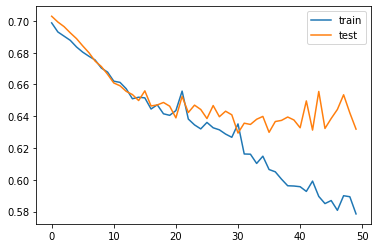

In [46]:
# plot history loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

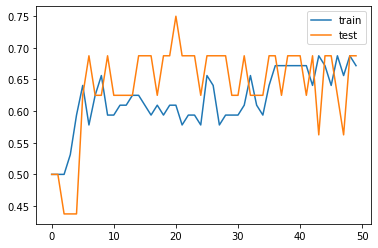

In [47]:
# plot history acc
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

# Validar Predição/Classificação

In [48]:
prediction = model.predict(X_test)


display(prediction)
display(y_test)

array([[0.47774467],
       [0.69962776],
       [0.30403894],
       [0.5263473 ],
       [0.26473087],
       [0.57809764],
       [0.23490188],
       [0.32592285],
       [0.57504046],
       [0.40236413],
       [0.50126165],
       [0.5286141 ],
       [0.5827342 ],
       [0.30698496],
       [0.48366603],
       [0.2535082 ]], dtype=float32)

array([[1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1]])